####Objective: Exploratory Data Analysis on medium posts dataset.

* Loading and getting basic insights.

* Preparing the data for further analysis.

* EDA to analyze the data and get information before modelling.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

####**1. Loading and getting basic insights.**

In [2]:
def read_csv():

  csv_path = Path('/content/drive/MyDrive/Leapfrog_internship/Project 3/medium_posts.csv')
  if csv_path.is_file():
    medium_post = pd.read_csv(csv_path, sep="\t", error_bad_lines = False)
  else:
    raise ValueError("File not found.")
  return medium_post

mediumPosts = read_csv()


In [3]:
mediumPosts.head()

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...


In [4]:
mediumPosts.count(axis = 0)

published    92191
domain       92191
url          92191
dtype: int64

* There are a total of 92191 number of examples in the dataset.
* Domain name is not useful in forecasting, so removing it in the future steps.
* All the given values are not unique, there is a chance that published date along with url is same for some rows.
* There are in total three features: published (date and time of the published article), domain, url (post published in medium).



####**2. Data Preparation**

In [5]:
#Checking for duplicates in the dataset
mediumPosts.duplicated().any()

True

In [6]:
# removing the duplicates from the dataset
mediumPosts = mediumPosts[['published', 'url']].drop_duplicates()
mediumPosts.duplicated().any()

False

In [7]:
#Checking the datatypes of the features in the dataframe
mediumPosts.dtypes

published    object
url          object
dtype: object

In [8]:
#Changing the datatype of published to datetime format for further processing
mediumPosts['published'] = pd.to_datetime(mediumPosts['published'])
mediumPosts.dtypes

published    datetime64[ns, UTC]
url                       object
dtype: object

In [9]:
#let's look at the dataframe by sorting it on the basis of time
mediumPosts.sort_values(by = ['published']).head(n = 3)

,published,url
50931,1970-01-01 00:00:00.001000+00:00,https://medium.com/iiot
40243,1970-01-01 00:00:00.001000+00:00,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...


In [10]:
mediumPosts.sort_values(by = ['published']).tail(n = 2)

,published,url
90927,2017-06-27 13:01:27.795000+00:00,https://medium.com/@AdsNative/pocketmath-reduc...
90673,2017-06-27 14:48:42.850000+00:00,https://medium.com/@charliedeets/thoughts-on-t...


* There are articles from the year 2012 to 2017.

* Medium's public release date was August 15, 2012. But, as there are data above, there are at least several rows with much earlier publication dates. They have somehow turned up in our dataset, but they are hardly legitimate ones. We will just trim our time series to keep only those rows that fall onto the period from August 15, 2012 to June 25, 2017.

In [11]:
mediumPosts = mediumPosts[(mediumPosts['published'] > '2012-08-15') & (mediumPosts['published'] < '2017-06-26')].sort_values(by=['published'])
mediumPosts.head(n = 3)

,published,url
24630,2012-08-15 00:25:03.373000+00:00,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419000+00:00,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502000+00:00,https://medium.com/i-m-h-o/the-world-is-social...


In [12]:
mediumPosts.tail(n = 2)

,published,url
72471,2017-06-25 23:41:48.295000+00:00,https://medium.com/parti-xyz-developers/%EA%B4...
83283,2017-06-25 23:51:43+00:00,http://www.johanr.com/blog/people-support-dreams


In [13]:
mediumPosts.count()

published    91806
url          91806
dtype: int64

* **385** rows are removed from the dataset on the basis of time significance and uniqueness.

**Aggregating and counting total posts publised in a day.**

As the objective is to predict the number of published posts, we will have to aggregate and count unique posts at each given point in time.

In [14]:
aggregate_posts = mediumPosts.groupby('published')[['url']].count()
aggregate_posts.columns = ['posts']
aggregate_posts.head()

,posts
published,
2012-08-15 00:25:03.373000+00:00,1
2012-08-15 00:25:29.419000+00:00,1
2012-08-15 00:34:59.502000+00:00,1
2012-08-15 00:40:10.773000+00:00,1
2012-08-15 00:58:25.898000+00:00,1


* Actual need was to get the number of posts a day. But at this moment all our data is divided into irregular time intervals that are less than a day. 

* We need to aggregate the posts counts by "**bins**" of a date size to fix the above problem. Further I have illustrated this concept in findings. 

In [15]:
aggregate_posts = aggregate_posts.resample('D').apply(sum)
aggregate_posts.head()

,posts
published,
2012-08-15 00:00:00+00:00,16
2012-08-16 00:00:00+00:00,11
2012-08-17 00:00:00+00:00,4
2012-08-18 00:00:00+00:00,2
2012-08-19 00:00:00+00:00,1


####**3. Exploratory data analysis**

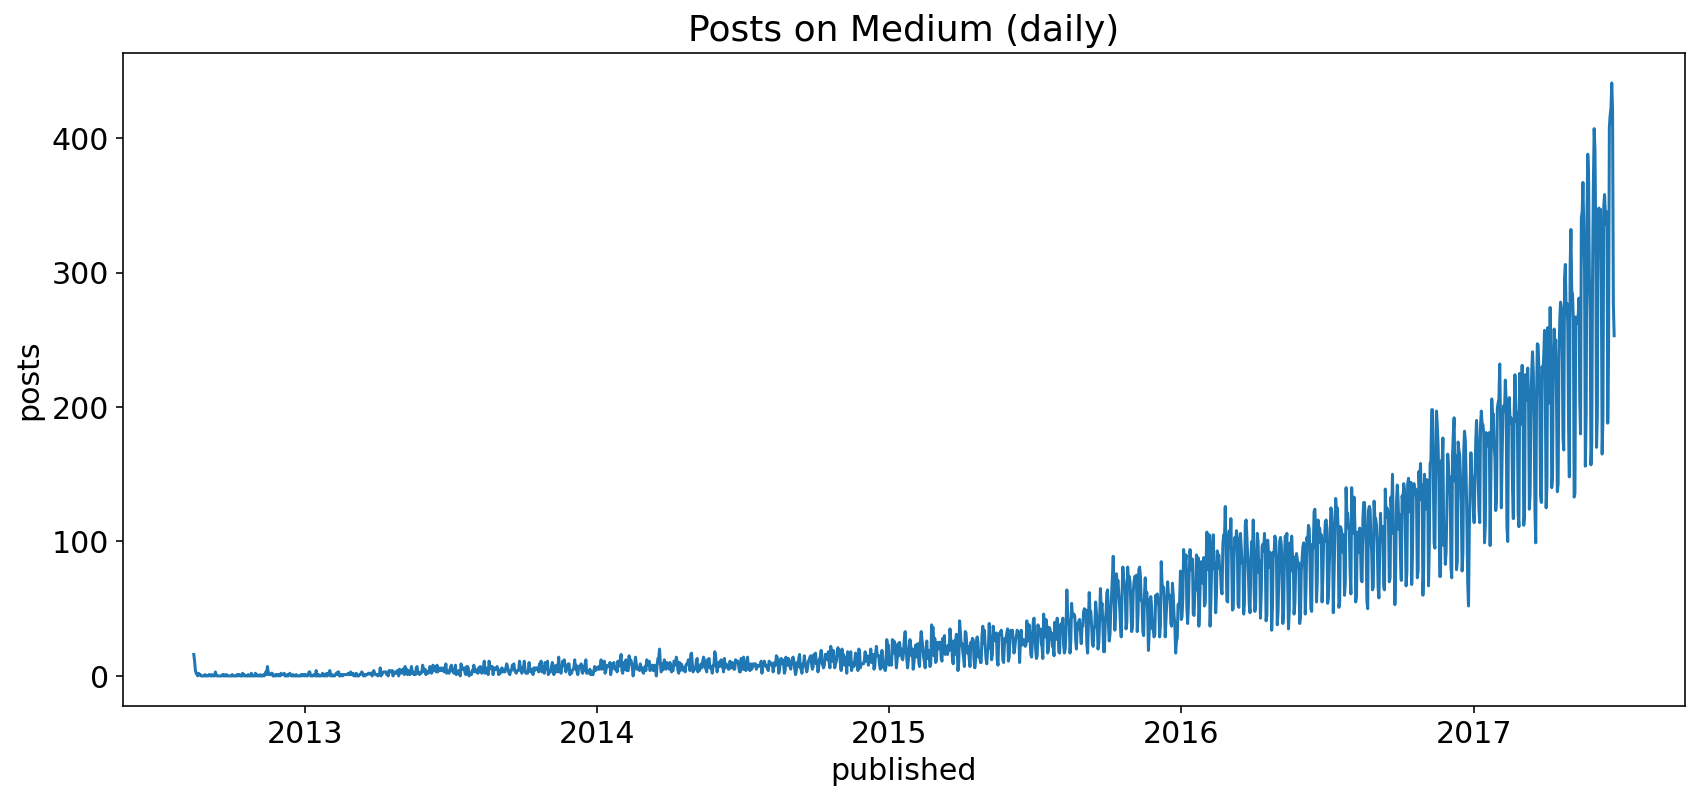

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 15

def line_plot(agg_posts, title):

  sns.lineplot(data = agg_posts, x = 'published', y = 'posts')
  plt.title(title)

line_plot(aggregate_posts, "Posts on Medium (daily)")

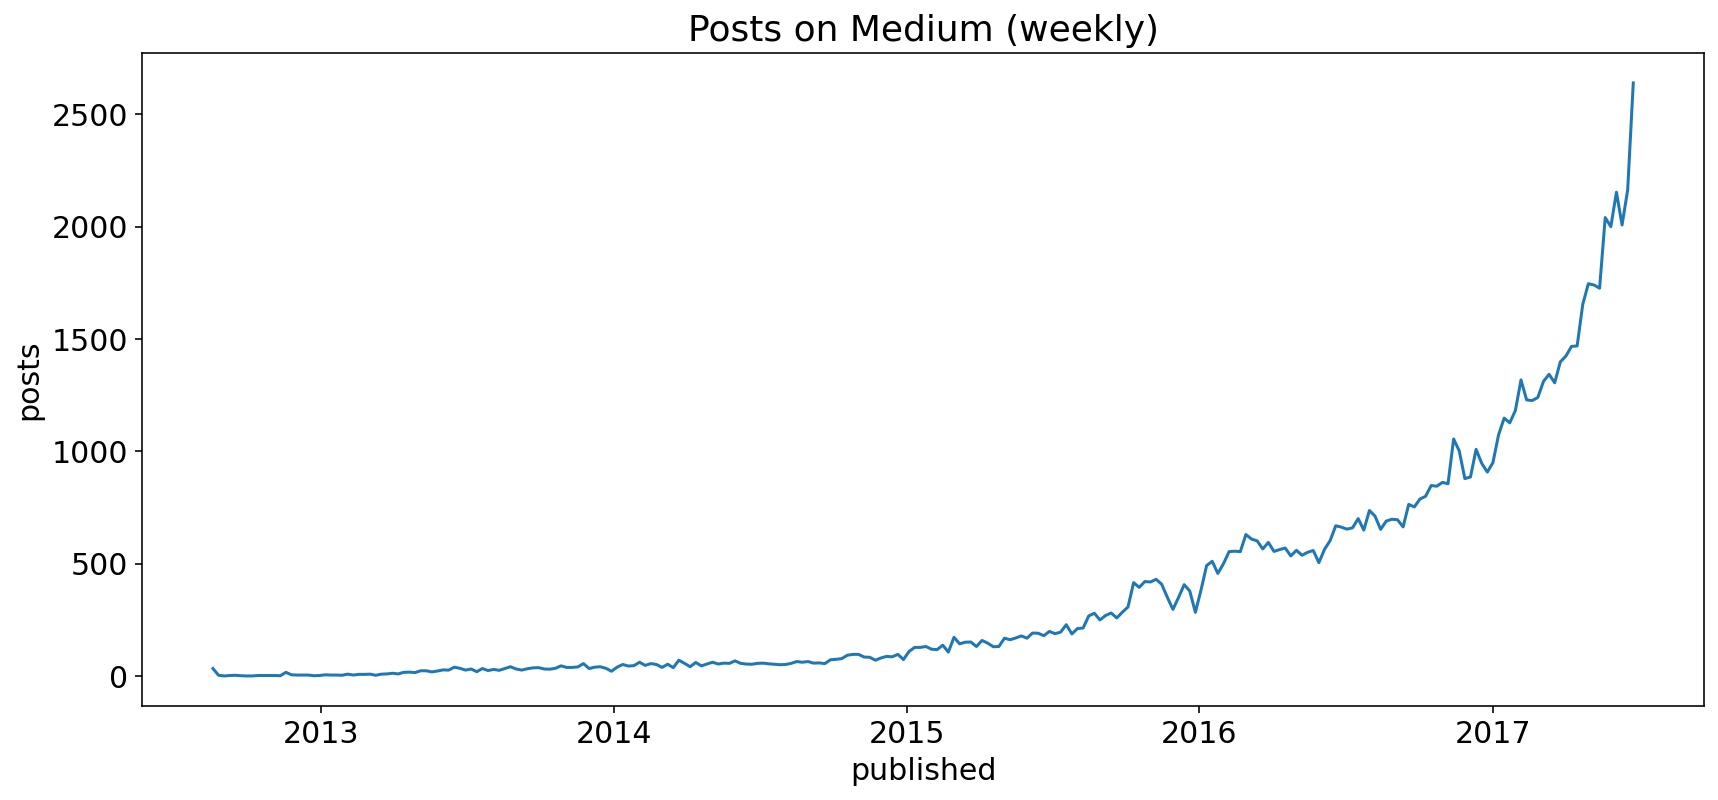

In [17]:
aggregate_weekly_posts = aggregate_posts.resample('W').apply(sum)
aggregate_posts.head()

line_plot(aggregate_weekly_posts, "Posts on Medium (weekly)")

* The above further downsampled chart seems to better for analytical perception.

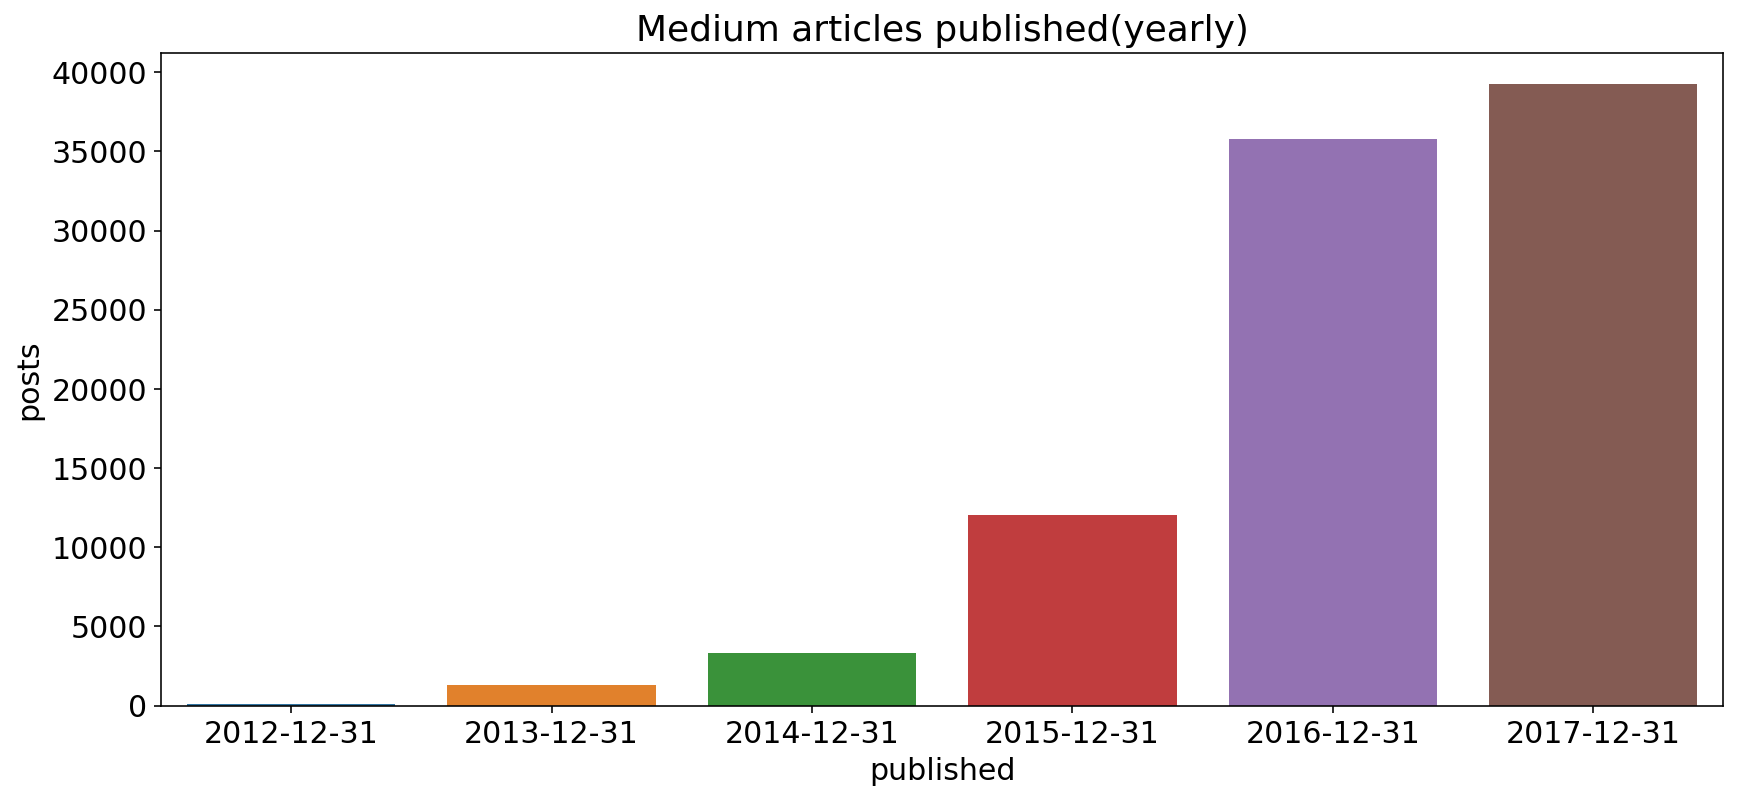

In [18]:
#visualizing a bar graph to see the number of increase in posts per year
def bar_chart(agg_posts, title):
  
  sns.barplot( x = agg_posts['published'], y = agg_posts['posts'])
  plt.title(title)

def get_publishedDate_df(aggregate_posts):
  aggregate_posts_yearly = aggregate_posts.resample('Y').apply(sum)
  date = pd.DataFrame(aggregate_posts_yearly.index)
  date['published'] = date['published'].dt.date
  total_aggregate_posts = pd.concat([aggregate_posts_yearly, date.set_index(aggregate_posts_yearly.index)], axis = 1)\

  return total_aggregate_posts

total_aggregate_posts = get_publishedDate_df(aggregate_posts) 
bar_chart(total_aggregate_posts, 'Medium articles published(yearly)')

Upto 2015, the curve is prettry flat, as it was the initial phase and actual trends seems to start from 2015. The values upto 2015 won't contribute much into the forecast quality in 2017 and they will increase noice in our predictions, taking data from 2015 up will train the model on more relevant data from the recent years. 

In [19]:
aggregate_posts_final = aggregate_posts.loc[aggregate_posts.index >= '2015-01-01']
aggregate_posts_final.head()

,posts
published,
2015-01-01 00:00:00+00:00,8
2015-01-02 00:00:00+00:00,11
2015-01-03 00:00:00+00:00,11
2015-01-04 00:00:00+00:00,8
2015-01-05 00:00:00+00:00,27
